# Preprocessing to for All Binance Historical Dataset

In [7]:
import pandas as pd
import pyarrow.parquet as pq

class preprocessing:
    def df_pp(path,freq):
        try:
            print(f'[\033[96mLOG\033[0m]Data {path} Reading')
            df = pq.read_table(source=path).to_pandas()
            df = df.iloc[-600:-200]
            print(f'[\033[92mSUCCESS\033[0m]Data Read Successfully')
        except:
            print(f'[\033[91mERROR\033[0m]Data Can Not Read {path} Successfully')
        try:
            print(f'[\033[96mLOG\033[0m]Data Conversion to {path} Begins.')
            df.rename(columns={'close': 'y'}, inplace=True, errors='raise')
            df['ds'] = df.index
            df.reset_index(drop=True, inplace=True)
            df = df[['ds','y']]
            date_range_in_minutes = pd.date_range(start = str(df.ds.values[0])[:19], end = str(df.ds.values[-1])[:19], freq=freq)
            date_df = pd.DataFrame(list(date_range_in_minutes), columns = ['ds'])
            date_df['ds'] = pd.to_datetime(date_df['ds']).astype('str')
            df['ds'] = pd.to_datetime(df['ds']).astype('str')
            all_date_df = date_df.merge(df, how = 'left',  on=["ds"])
            all_date_df = all_date_df.fillna(method='ffill')
            print(f'[\033[92mSUCCESS\033[0m]Data Converted Successfully')
            return all_date_df
        except:
            print(f'[\033[91mERROR\033[0m]Data Can Not Converted {path} Successfully')

In [8]:
df = preprocessing.df_pp('/content/drive/MyDrive/BIG_DATA_PROJECT/Dataset/BTC-EUR.parquet', 'T')

[LOG]Data /content/drive/MyDrive/BIG_DATA_PROJECT/Dataset/BTC-EUR.parquet Reading
[SUCCESS]Data Read Successfully
[LOG]Data Conversion to /content/drive/MyDrive/BIG_DATA_PROJECT/Dataset/BTC-EUR.parquet Begins.
[SUCCESS]Data Converted Successfully


In [9]:
df.tail()

,ds,y
495,2022-03-11 22:15:00,35708.468750
496,2022-03-11 22:16:00,35712.550781
497,2022-03-11 22:17:00,35709.011719
498,2022-03-11 22:18:00,35722.570312
499,2022-03-11 22:19:00,35739.898438


# Extracting Future form Dataset and Historical Values as Lag for Forecasting

In [10]:
import pandas as pd

class feature_extractor:
    def create_features(df):
        """
        Creates time series features from datetime index
        """
        #df['ds'] = pd.to_datetime(df['ds']).dt.date
        try:
            df = df.set_index('ds')
        except:
            pass
        
        df['date'] = pd.to_datetime(df.index, errors='coerce')

        
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        df['hour'] = df['date'].dt.hour
        df['minute'] = df['date'].dt.minute
        
        X = df[['y', 'dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear',
            'hour', 'minute']]
        
        X.index=df.index
        return X

    def series_lagger(data, full_data, n_in=1, n_out=1, dropnan=True):
        """
        Frame a time series as a supervised learning dataset.
        Arguments:
            data: Sequence of observations as a list or NumPy array.
            n_in: Number of lag observations as input (X).
            n_out: Number of observations as output (y).
            dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
            Pandas DataFrame of series framed for supervised learning.
        """
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('lag%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('lag%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('lag%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)

        #print(agg.columns[:-1])
        for i in agg.columns[:-1]:
            full_data[i] = agg[i]
        return full_data[n_in:]


In [11]:
df = feature_extractor.create_features(df) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [12]:
df.tail()

,y,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour,minute
ds,,,,,,,,,,
2022-03-11 22:15:00,35708.468750,4,1,3,2022,70,11,10,22,15
2022-03-11 22:16:00,35712.550781,4,1,3,2022,70,11,10,22,16
2022-03-11 22:17:00,35709.011719,4,1,3,2022,70,11,10,22,17
2022-03-11 22:18:00,35722.570312,4,1,3,2022,70,11,10,22,18
2022-03-11 22:19:00,35739.898438,4,1,3,2022,70,11,10,22,19


In [13]:
df = feature_extractor.series_lagger(df[['y']], full_data = df, n_in = 10, n_out=1, dropnan=True)

In [14]:
df

,y,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour,minute,lag1(t-10),lag1(t-9),lag1(t-8),lag1(t-7),lag1(t-6),lag1(t-5),lag1(t-4),lag1(t-3),lag1(t-2),lag1(t-1)
ds,,,,,,,,,,,,,,,,,,,,
2022-03-11 14:10:00,35796.050781,4,1,3,2022,70,11,10,14,10,35731.750000,35705.480469,35710.398438,35730.351562,35725.820312,35784.769531,35812.941406,35820.738281,35809.441406,35813.289062
2022-03-11 14:11:00,35771.640625,4,1,3,2022,70,11,10,14,11,35705.480469,35710.398438,35730.351562,35725.820312,35784.769531,35812.941406,35820.738281,35809.441406,35813.289062,35796.050781
2022-03-11 14:12:00,35740.558594,4,1,3,2022,70,11,10,14,12,35710.398438,35730.351562,35725.820312,35784.769531,35812.941406,35820.738281,35809.441406,35813.289062,35796.050781,35771.640625
2022-03-11 14:13:00,35766.671875,4,1,3,2022,70,11,10,14,13,35730.351562,35725.820312,35784.769531,35812.941406,35820.738281,35809.441406,35813.289062,35796.050781,35771.640625,35740.558594
2022-03-11 14:14:00,35803.820312,4,1,3,2022,70,11,10,14,14,35725.820312,35784.769531,35812.941406,35820.738281,35809.441406,35813.289062,35796.050781,35771.640625,35740.558594,35766.671875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-11 22:15:00,35708.468750,4,1,3,2022,70,11,10,22,15,35705.761719,35705.761719,35663.738281,35661.558594,35686.390625,35667.031250,35696.550781,35694.539062,35707.000000,35728.621094
2022-03-11 22:16:00,35712.550781,4,1,3,2022,70,11,10,22,16,35705.761719,35663.738281,35661.558594,35686.390625,35667.031250,35696.550781,35694.539062,35707.000000,35728.621094,35708.468750
2022-03-11 22:17:00,35709.011719,4,1,3,2022,70,11,10,22,17,35663.738281,35661.558594,35686.390625,35667.031250,35696.550781,35694.539062,35707.000000,35728.621094,35708.468750,35712.550781


# Model Creation And Model Tuning include K-Fold Cross Validation with Library PyCaret

In [15]:
import numpy as np
import pandas as pd
import jinja2
from pycaret.regression import *
import datetime



class statistical_models():
    def __init__(self, model_id):
      self.model_id = model_id

    def model_creator(self, df, save_path = '', target = 'y'):
        try:
            print(f'[\033[96mLOG\033[0m]Enviroment Creation Begins')
            setup(df, target = 'y', silent = True, verbose = False)
            print(f'[\033[92mSUCCESS\033[0m]Enviroment Has Created Successfully')
        except:
            print(f'[\033[91mERROR\033[0m]Enviroment Setup Error! All be demolished soon!')
        try:
            print(f'[\033[96mLOG\033[0m]{statistical_models.model_pool()[self.model_id]} Creation Begins')
            model = create_model(self.model_id, verbose = False)
            print(f'[\033[92mSUCCESS\033[0m]Model {statistical_models.model_pool()[self.model_id]} Created Successfully')
        except:
            print(f'[\033[91mERROR\033[0m]Model {statistical_models.model_pool()[self.model_id]} Not Created Successfully!')
        try:
            print(f'[\033[96mLOG\033[0m]{statistical_models.model_pool()[self.model_id]} Tuning Begins')
            tuned_model = tune_model(model, verbose = False)
            print(f'[\033[92mSUCCESS\033[0m]Model {statistical_models.model_pool()[self.model_id]} Tuning Process Has Ended Successfully')
        except:
            print(f'[\033[91mERROR\033[0m]Model {statistical_models.model_pool()[self.model_id]} Couldn\'t Tuned Successfully')

        try:
            print(f'[\033[96mLOG\033[0m]{statistical_models.model_pool()[self.model_id]} Tuned Version Saving...')
            now = datetime.datetime.now()
            save_model(tuned_model,
                      f'{save_path}{self.model_id}_model_{now.year}_{now.month}_{now.day}-{now.hour}:{now.minute}:{now.second}',
                      verbose = False)
            print(f'[\033[92mSUCCESS\033[0m]Model {statistical_models.model_pool()[self.model_id]} Saved Successfully!')
        except:
            print(f'[\033[91mERROR\033[0m]Model {statistical_models.model_pool()[self.model_id]} Couldn\'t Saved')

    def model_pool():
        models = {'lr':'Linear Regression',
                  'lasso': 'Lasso Regression',
                  'ridge': 'Ridge Regression',
                  'en': 'Elastic Net',
                  'lar': 'Least Angle Regression',
                  'llar': 'Lasso Least Angle Regression',
                  'omp': 'Orthogonal Matching Pursuit',
                  'br': 'Bayesian Ridge',
                  'ard': 'Automatic Relevance Determination',
                  'par': 'Passive Aggressive Regressor',
                  'ransac': 'Random Sample Consensus',
                  'tr': 'TheilSen Regressor',
                  'huber': 'Huber Regressor',
                  'kr': 'Kernel Ridge',
                  'svm': 'Support Vector Regression',
                  'knn': 'K Neighbours Regressor',
                  'dt': 'Decisiopn Tree Regressor',
                  'rf': 'Random Forest Regressor',
                  'et': 'Extra Trees Regressor',
                  'ada': 'AdaBoost Regressor',
                  'gbr': 'Gradient Boosting Regressor',
                  'mlp': 'MLP Regressor',
                  'xgboost': 'Extreme Gradient Boosting',
                  'lightgbm': 'Light Gradient Boosting Machine',
                  'catboost': 'CatBoost Regressor'}
        return models


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [16]:
for model in statistical_models.model_pool().keys():
    model_to_train = statistical_models(model)
    model_to_train.model_creator(df,
                                 save_path = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/', 
                                 target = 'y')

[LOG]Enviroment Creation Begins
[SUCCESS]Enviroment Has Created Successfully
[LOG]Linear Regression Creation Begins
[SUCCESS]Model Linear Regression Created Successfully
[LOG]Linear Regression Tuning Begins
[SUCCESS]Model Linear Regression Tuning Process Has Ended Successfully
[LOG]Linear Regression Tuned Version Saving...
[SUCCESS]Model Linear Regression Saved Successfully!
[LOG]Enviroment Creation Begins
[SUCCESS]Enviroment Has Created Successfully
[LOG]Lasso Regression Creation Begins
[SUCCESS]Model Lasso Regression Created Successfully
[LOG]Lasso Regression Tuning Begins
[SUCCESS]Model Lasso Regression Tuning Process Has Ended Successfully
[LOG]Lasso Regression Tuned Version Saving...
[SUCCESS]Model Lasso Regression Saved Successfully!
[LOG]Enviroment Creation Begins
[SUCCESS]Enviroment Has Created Successfully
[LOG]Ridge Regression Creation Begins
[SUCCESS]Model Ridge Regression Created Successfully
[LOG]Ridge Regression Tuning Begins
[SUCCESS]Model Ridge Regression Tuning Process

# Forecastor Module Include Argument Parsing(Disabled for Jupyter)

In [ ]:
from pycaret.regression import load_model, predict_model
#from preprocessor import preprocessing
#from feature_extractor import feature_extractor
import numpy as np
import pandas as pd
import argparse


def forecastor(df, model, forecast_range_min = 10, num_of_lag = 10):
    '''
    forecastor(df = df,
           model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Models_Deneme/omp_model_2022_6_18-11:33:24',
           forecast_range_min = 10,
           num_of_lag = 10)
    '''

    # Dates and Forecasts to be appended
    try:
        print(f'[\033[96mLOG\033[0m]Loading Model {model}')
        model = load_model(model[:-4])
        print(f'[\033[92mSUCCESS\033[0m]Model Loaded Successfully')
    except:
        print(f'[\033[91mERROR\033[0m]Model Couldn\'t be Obtained Properly')
        print(f'[\033[93mHELP\033[0m]Check Your Model Path')
        return


    try:
        print(f'[\033[96mLOG\033[0m]Obtaining Data')
        last_df = df.tail(1).copy()
        dates_of_forecast = np.array([])
        forecasts = np.array([])
        print(f'[\033[92mSUCCESS\033[0m]Data Successfully Obtained')
    except:
        print(f'[\033[91mERROR\033[0m]Data Couldn\'t be Obtained')
        print(f'[\033[93mHELP\033[0m]Check Your Data Path')
        return

    try:
        print(f'[\033[96mLOG\033[0m]Forecasting Begining')
        for ff in range(forecast_range_min):

            # forecast one
            try:
                pred = predict_model(model, last_df, verbose = False)['Label'].values[0]
            except:
                print(f'[\033[91mERROR\033[0m]Forecast Error at Step {ff}')
                break

            # Lag shifting
            try:
                for i in range(num_of_lag, 1, -1):
                    last_df[f'lag1(t-{str(i)})'] = last_df[f'lag1(t-{str(i - 1)})']
                last_df['lag1(t-1)'] = pred
            except:
                print(f'[\033[91mERROR\033[0m]Lag Shifting Error at Step {ff} Inside Data')
                break

            # append prediction to array
            forecasts = np.append(forecasts, pred)

            try:
                # Adding one minute
                last_df.index = pd.to_datetime(last_df.index.astype(str)) + pd.DateOffset(minutes = 1)
                df_dater = feature_extractor.create_features(last_df)
            except:
                print(f'[\033[91mERROR\033[0m]Date Feature Creation Error at Step {ff} Inside Data')
                break


            try:
                for cols,dates in list(zip(df_dater.iloc[:,1:].columns, df_dater.iloc[:,1:].values[0])):
                    last_df[cols] = dates
            except:
                print(f'[\033[91mERROR\033[0m]Date Feature Append Error at Step {ff} with Forecast Data')
                break

            try:
                # append prediction to array
                dates_of_forecast = np.append(dates_of_forecast, df_dater.index.astype(str))
            except:
                print(f'[\033[91mERROR\033[0m]Append Error {ff} with Forecast Data')
                break


        print(f'[\033[92mSUCCESS\033[0m]Forecasting Successfully Done')

    except:
        print(f'[\033[91mERROR\033[0m]Couldn\'t Forecasted Properly')

    print(f'[\033[96mLOG\033[0m]Creating Forecast Dataframe')
    try:

        df_return = pd.DataFrame(np.array(list(zip(dates_of_forecast,forecasts))), columns = ['Dates', 'Forecasts'])
        df_return['Dates'] = pd.to_datetime(df_return['Dates'])
        print(f'[\033[92mSUCCESS\033[0m]Forecasting Dataframe Successfully Created')

    except:
        print(f'[\033[91mERROR\033[0m]Couldn\'t Create Foreacasting Dataframe!')
    
    return df_return

'''
def parse_opt():
    parser = argparse.ArgumentParser()
    # df, model, forecast_range_min = 10, num_of_lag = 10
    parser.add_argument('--df', help = 'Path to your parquet file from binance dataset')
    parser.add_argument('--model', help = 'Path to your model')
    parser.add_argument('--forecast_range_min', default = 10, help = 'Minimum minute to be forecasted')
    parser.add_argument('--num_of_lag', default = 10, help = 'lag range which you trained on your model')
    opt = parser.parse_args()
    return opt

def main(df, model, forecast_range_min, num_of_lag):
    df = preprocessing.df_pp(df, freq = 'T')
    df = feature_extractor.create_features(df) 
    df = feature_extractor.series_lagger(df[['y']], full_data = df, n_in = 10, n_out=1, dropnan=True)
    
    df_out = forecastor(df, model, int(forecast_range_min), int(num_of_lag))

    print(df_out)


if __name__ == '__main__':
    opt = parse_opt()
    main(**vars(opt))
'''


In [29]:
forecastor(df[:-10],
           model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl',
           forecast_range_min = 110,
           num_of_lag = 10)

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


,Dates,Forecasts
0,2022-03-11 22:10:00,35676.83146686491
1,2022-03-11 22:11:00,35689.66466094872
2,2022-03-11 22:12:00,35695.569369075834
3,2022-03-11 22:13:00,35703.68712122983
4,2022-03-11 22:14:00,35709.00290609244
...,...,...
105,2022-03-11 23:55:00,35750.32621231268
106,2022-03-11 23:56:00,35749.68377529154
107,2022-03-11 23:57:00,35749.03798695729
108,2022-03-11 23:58:00,35748.39165365355


In [36]:
real = df[20:400].y.values


forecasts = forecastor(df[:20],
                        model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl',
                        forecast_range_min = 380,
                        num_of_lag = 10).Forecasts.values
yhat = [float(i) for i in forecasts]

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


# Error Metrics

In [60]:
import numpy as np

class error_metrics:
    def mape(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def mse(y_true, y_pred):
        return np.square(np.subtract(y_true, y_pred)).mean()

    def mae(y_true, y_pred):
        return np.sum(np.absolute((y_true - y_pred)))

    def rmse(y_true, y_pred):
        rms = np.sqrt(error_metrics.mse(y_true, y_pred))
        return rms

# Analyzing All Models and Selecting Better Models Between Them

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lr_model_2022_6_26-11:24:45.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


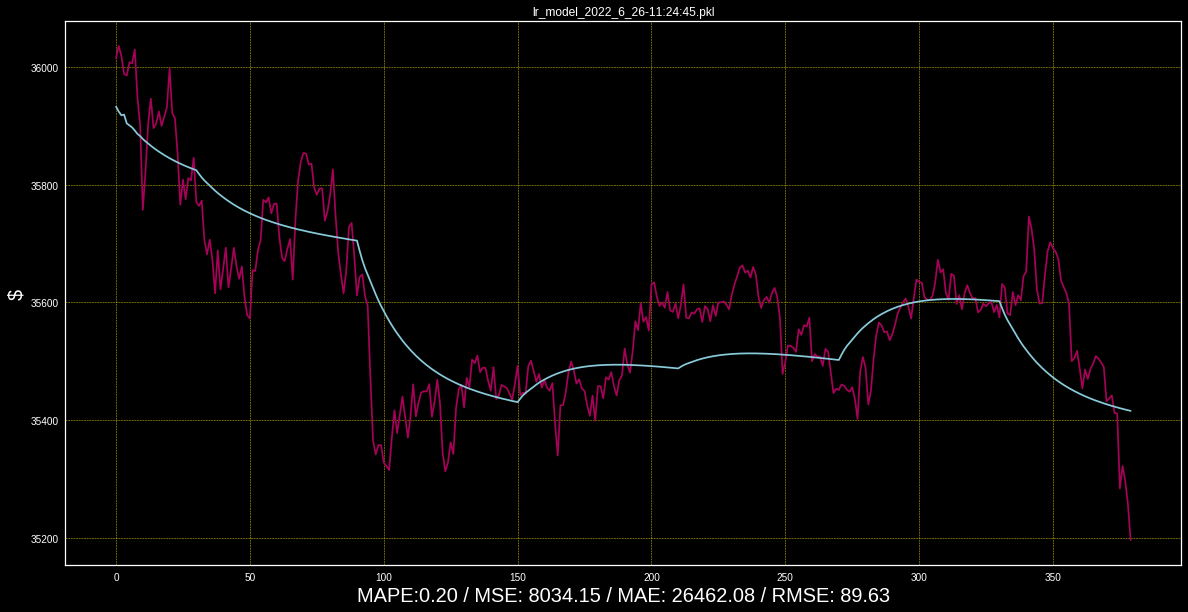

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lasso_model_2022_6_26-11:24:48.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


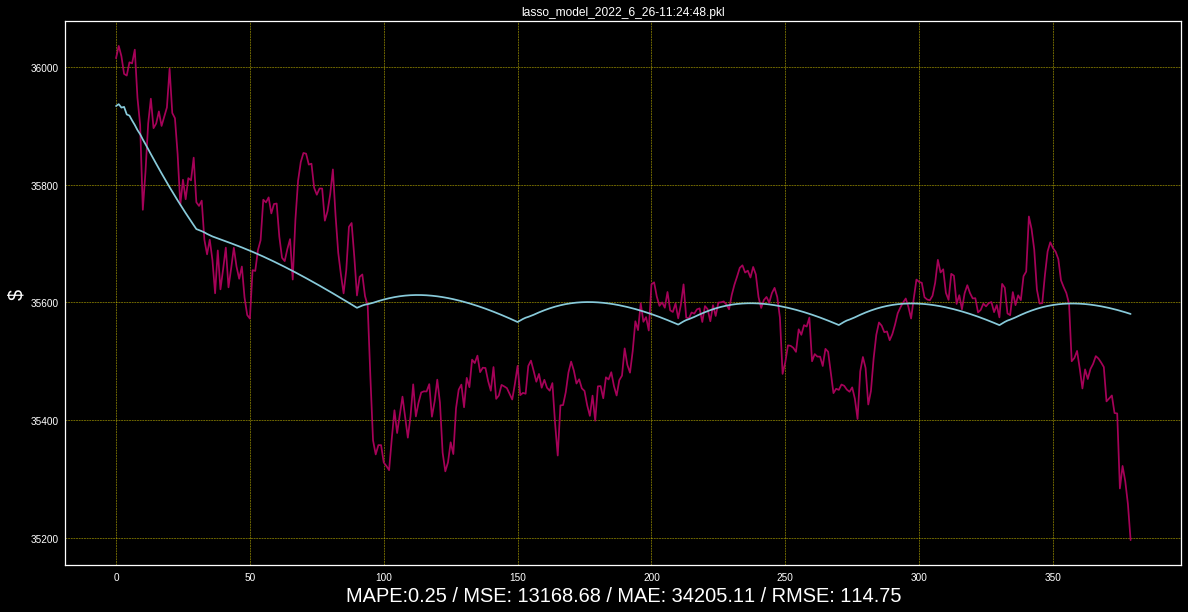

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ridge_model_2022_6_26-11:24:51.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


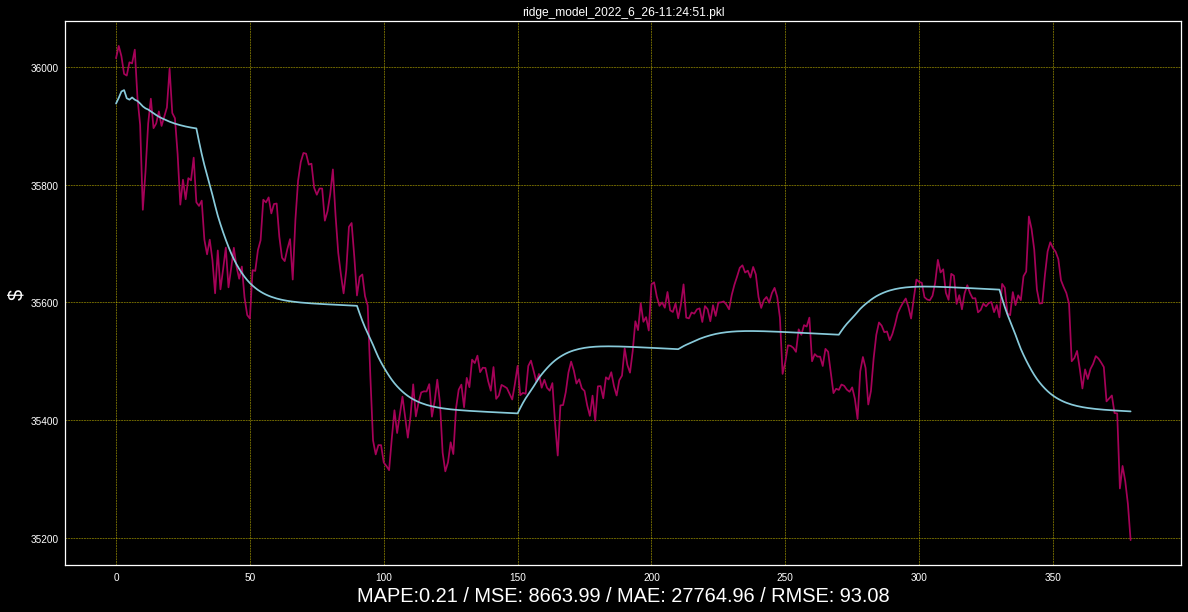

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/en_model_2022_6_26-11:24:54.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


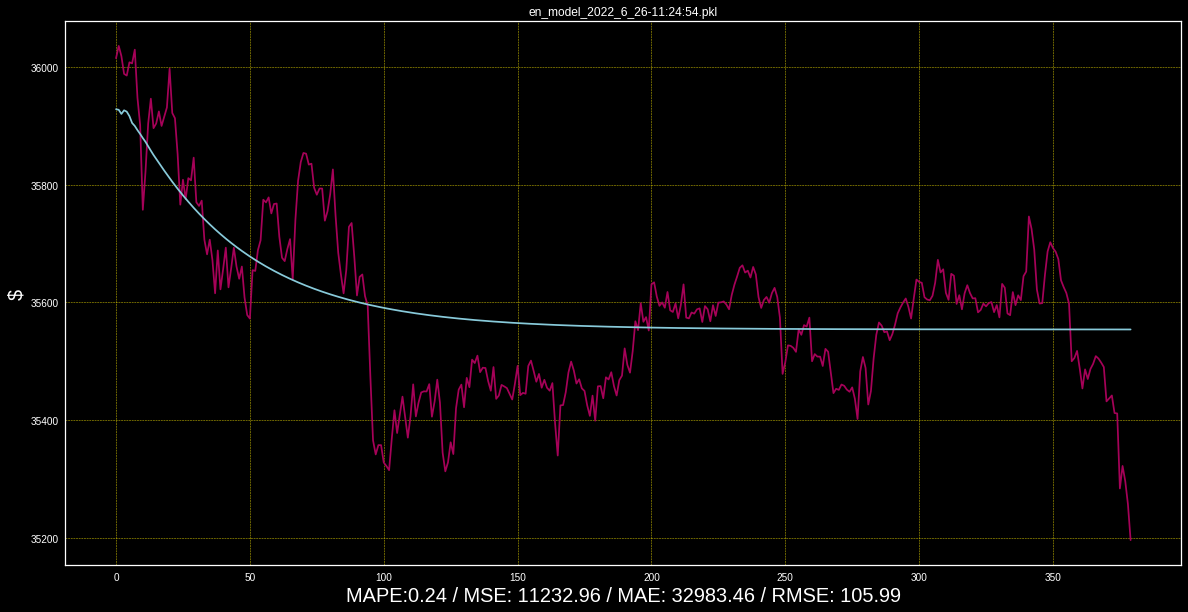

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lar_model_2022_6_26-11:24:57.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


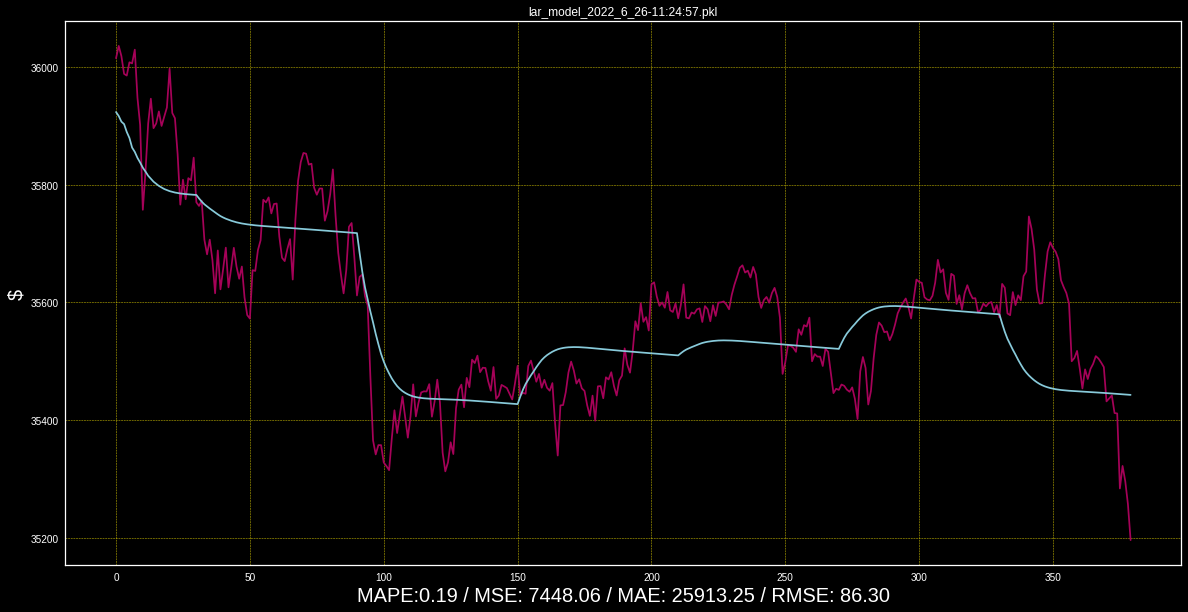

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/llar_model_2022_6_26-11:24:59.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


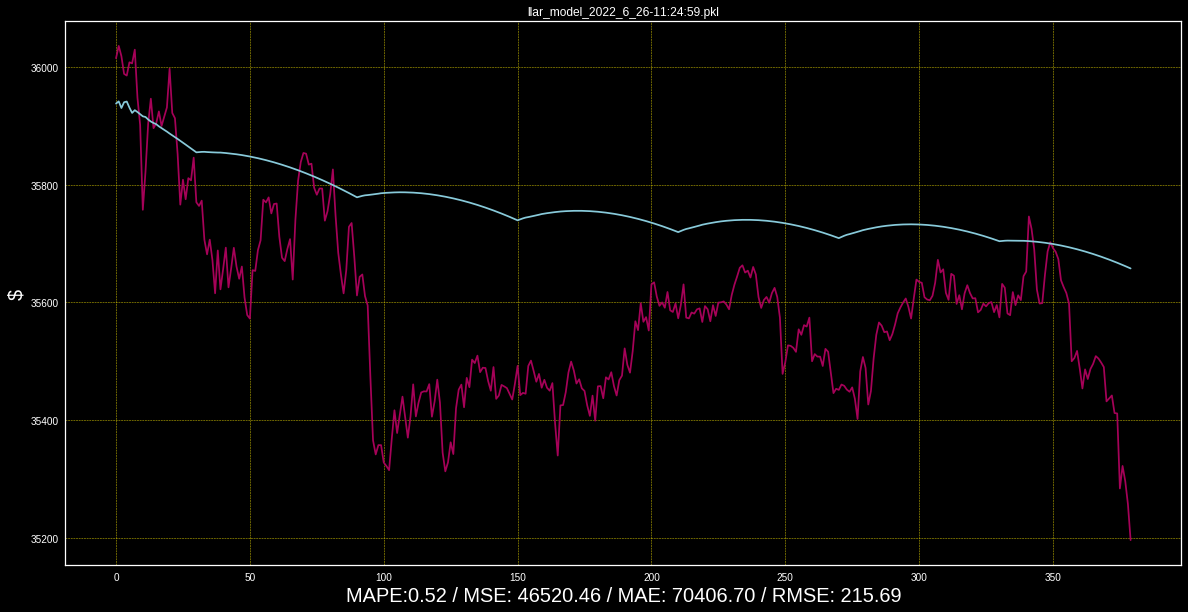

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


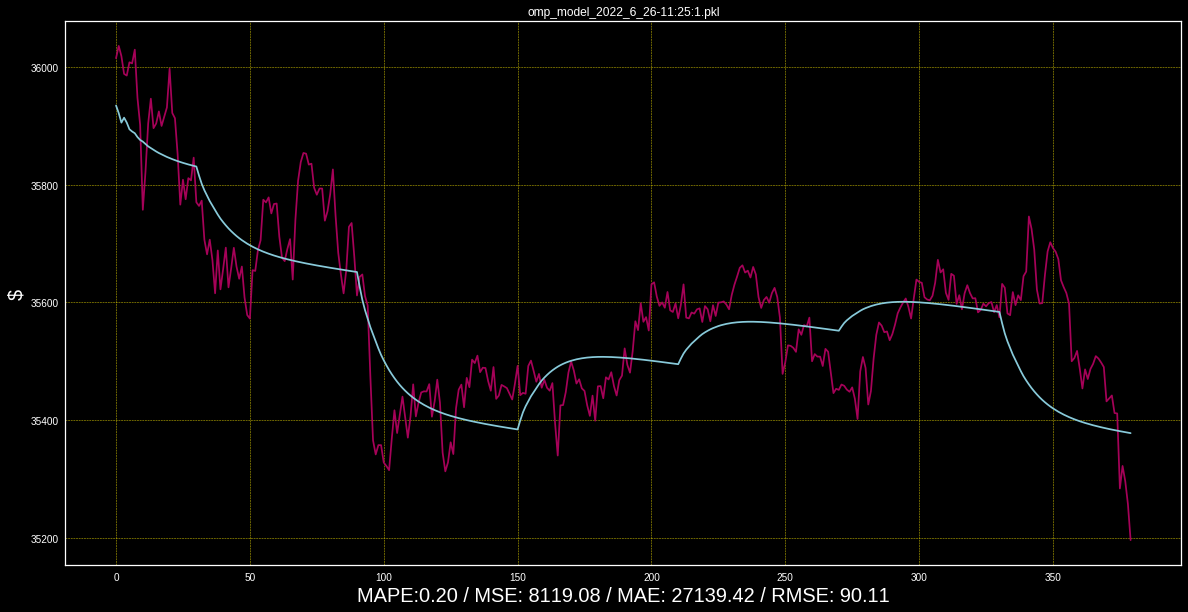

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/br_model_2022_6_26-11:25:4.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


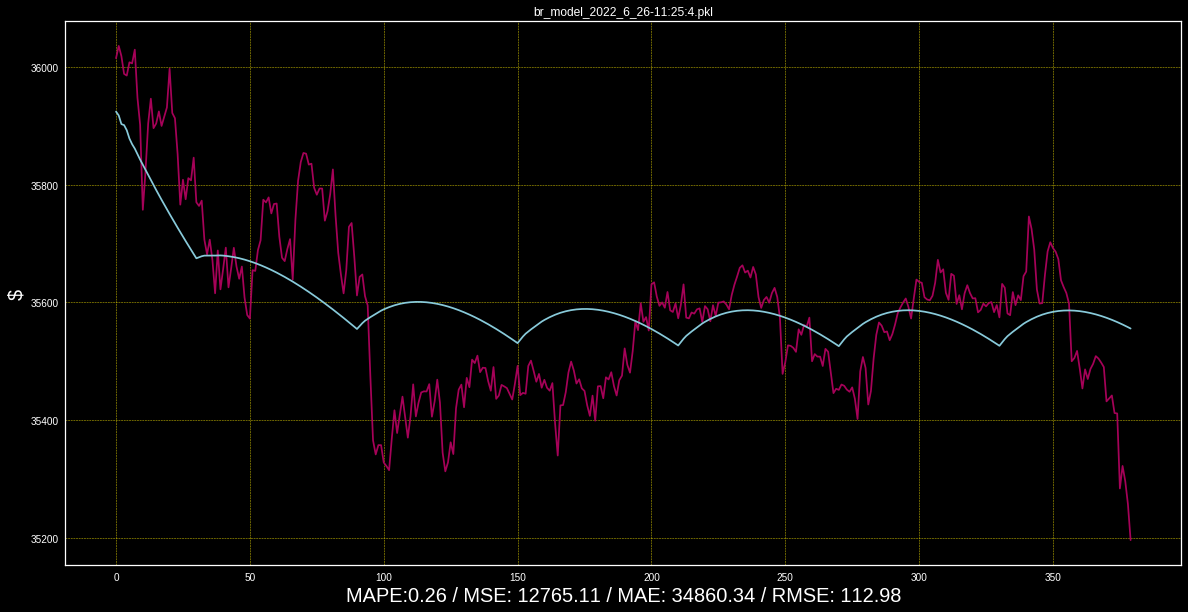

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ard_model_2022_6_26-11:25:14.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


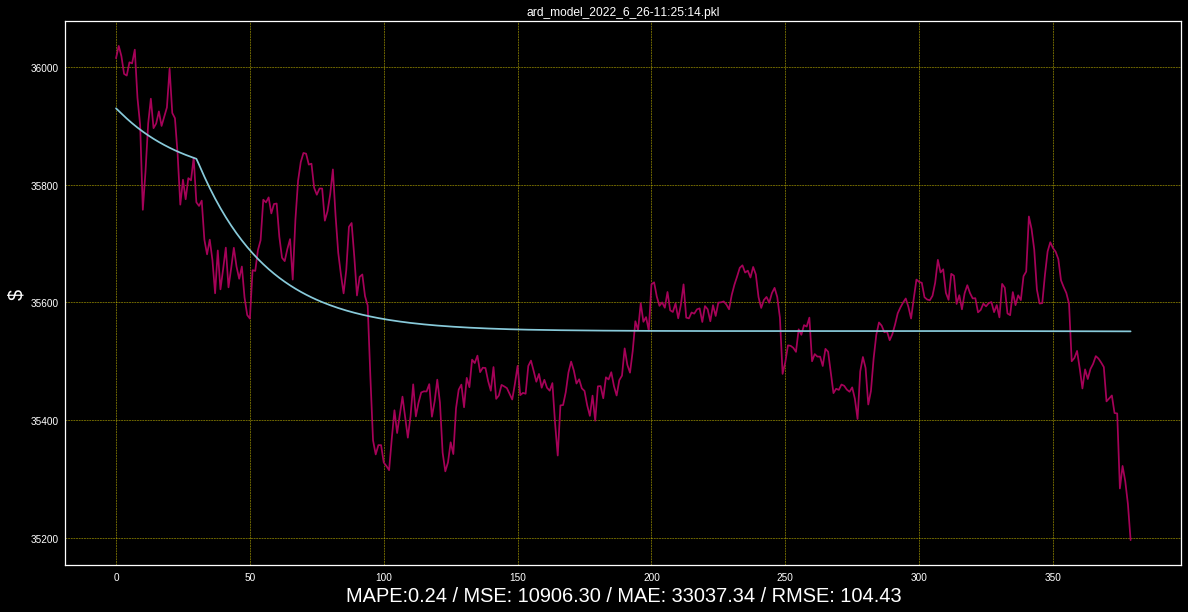

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/par_model_2022_6_26-11:25:18.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


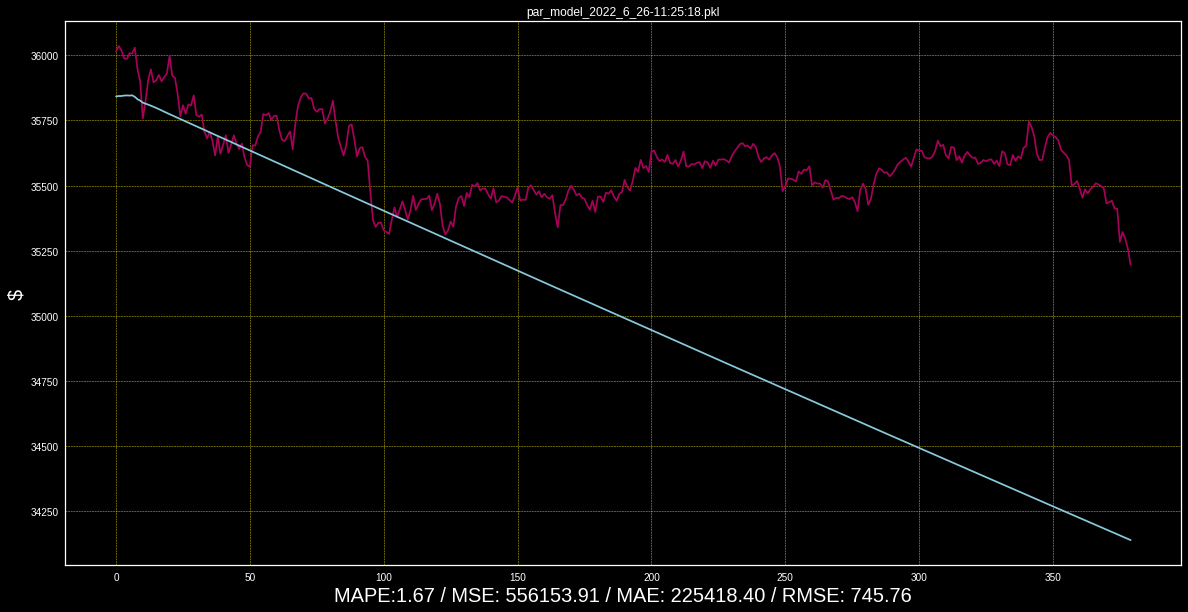

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ransac_model_2022_6_26-11:25:21.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


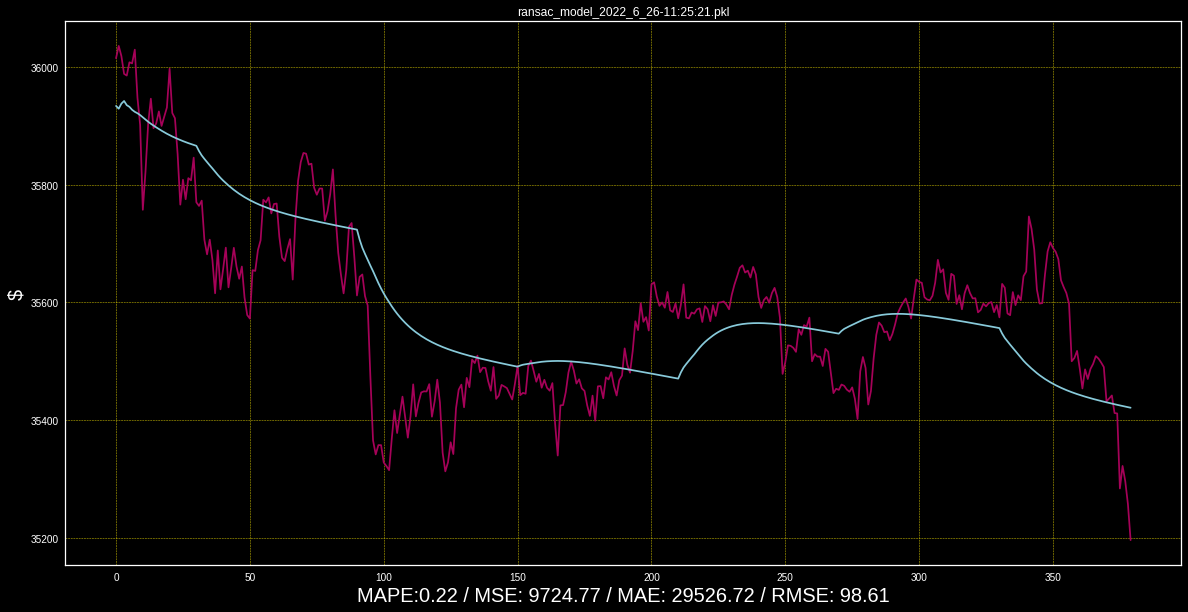

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/tr_model_2022_6_26-11:26:54.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


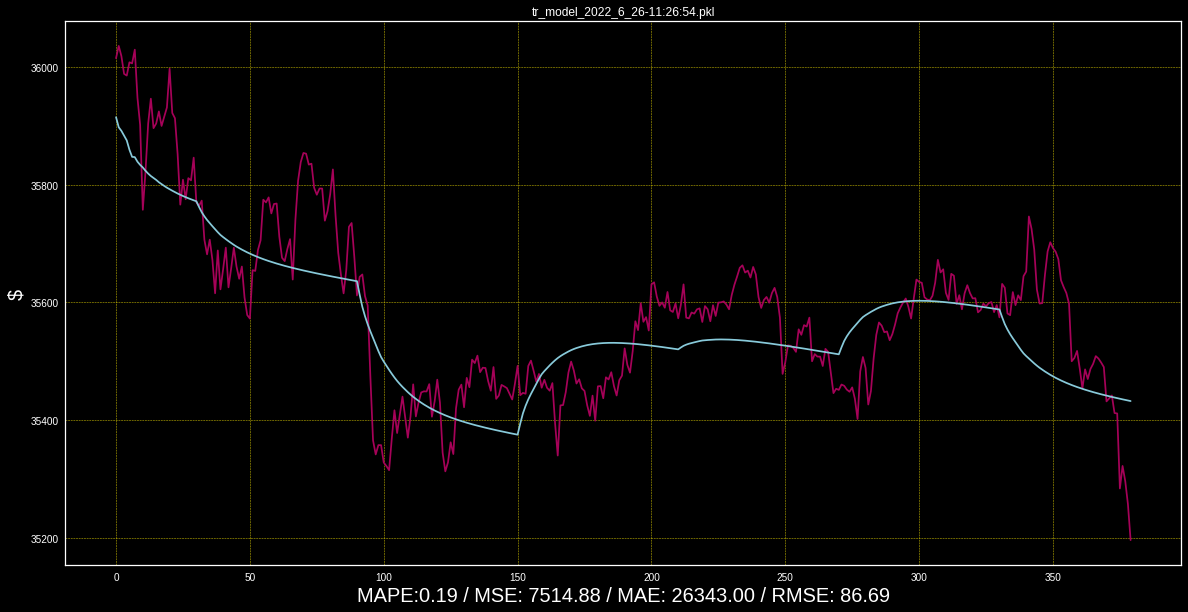

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/huber_model_2022_6_26-11:27:1.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


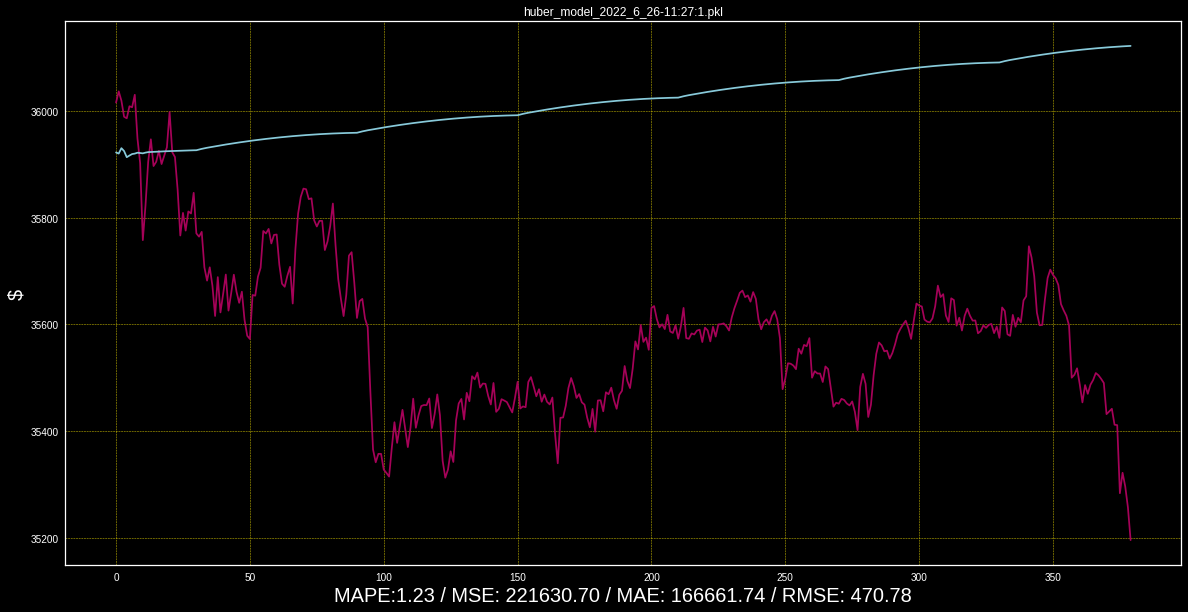

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/kr_model_2022_6_26-11:27:4.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


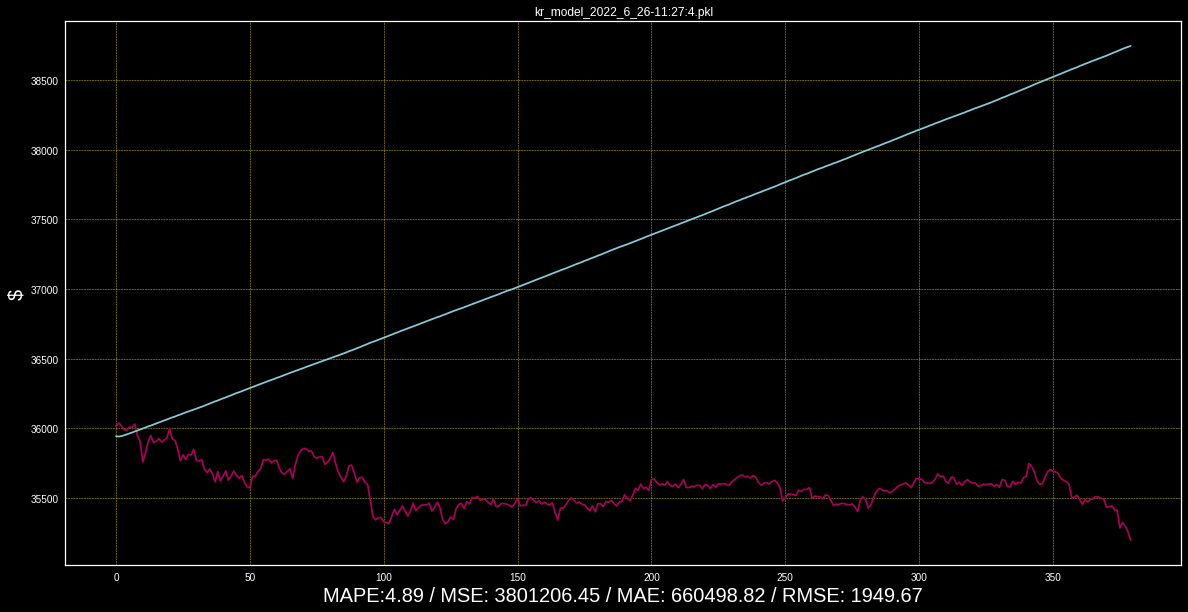

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/svm_model_2022_6_26-11:27:8.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


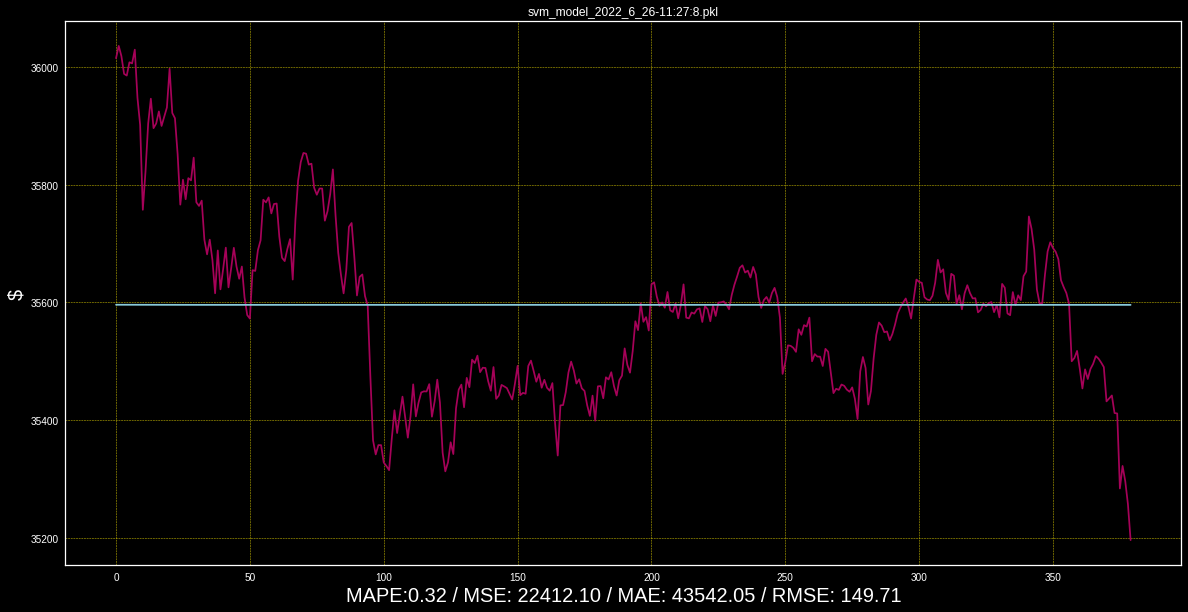

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/knn_model_2022_6_26-11:27:16.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


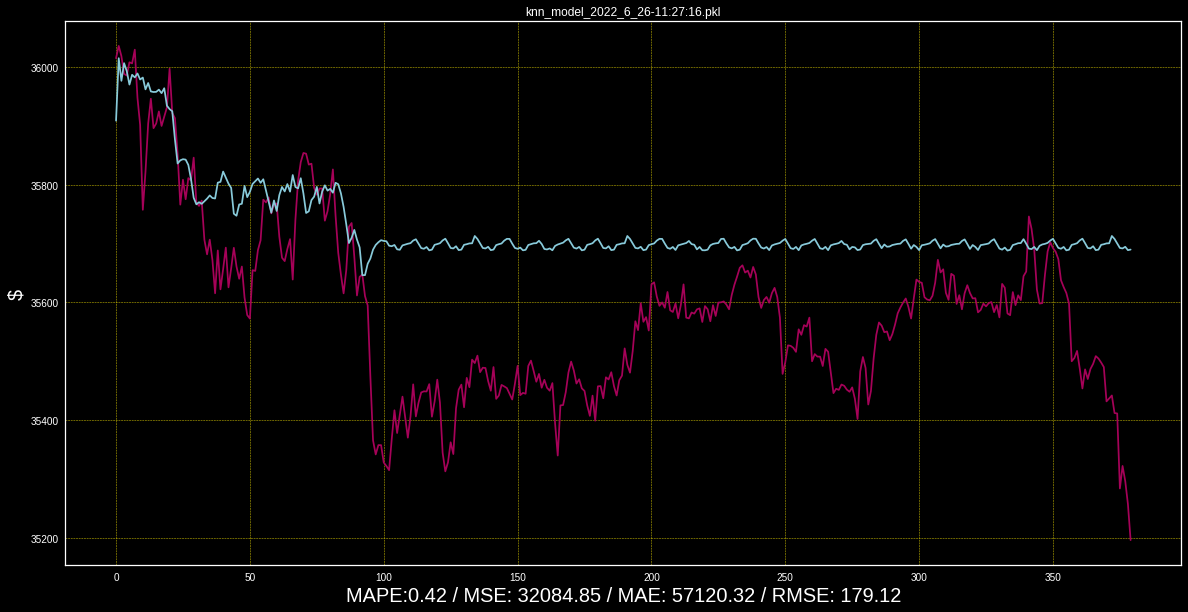

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/dt_model_2022_6_26-11:27:20.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


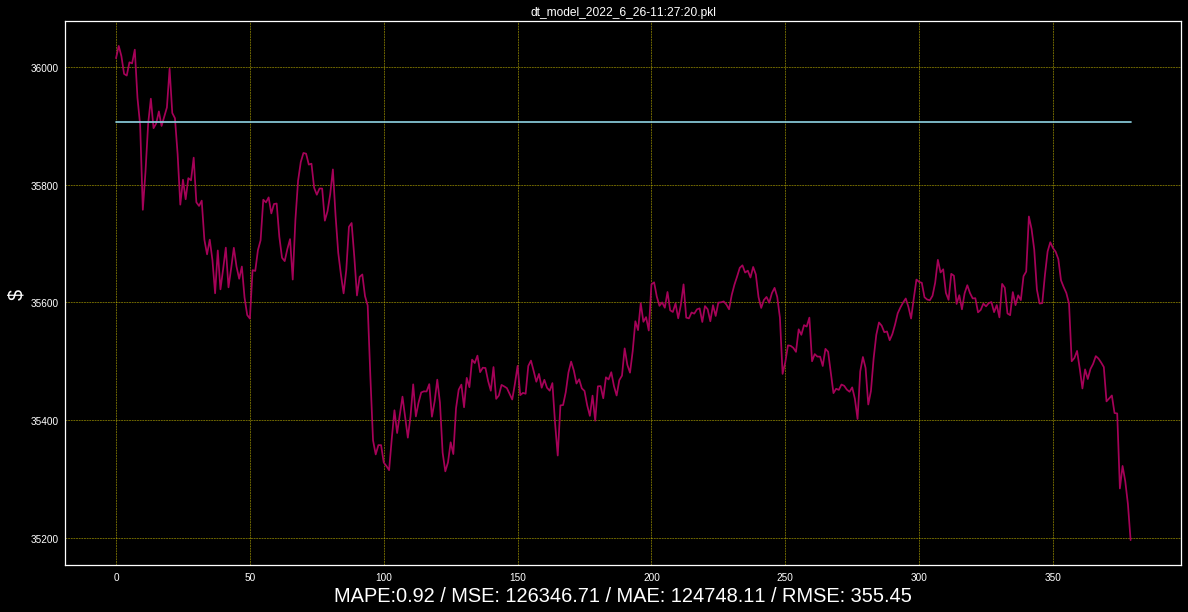

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/rf_model_2022_6_26-11:28:54.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


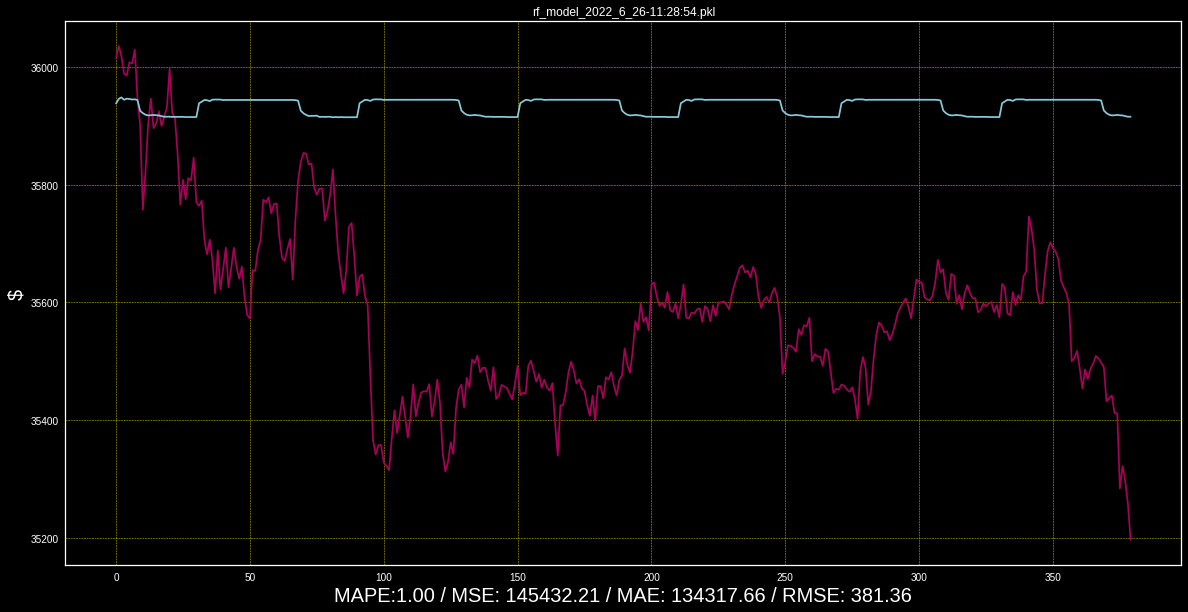

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/et_model_2022_6_26-11:30:8.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


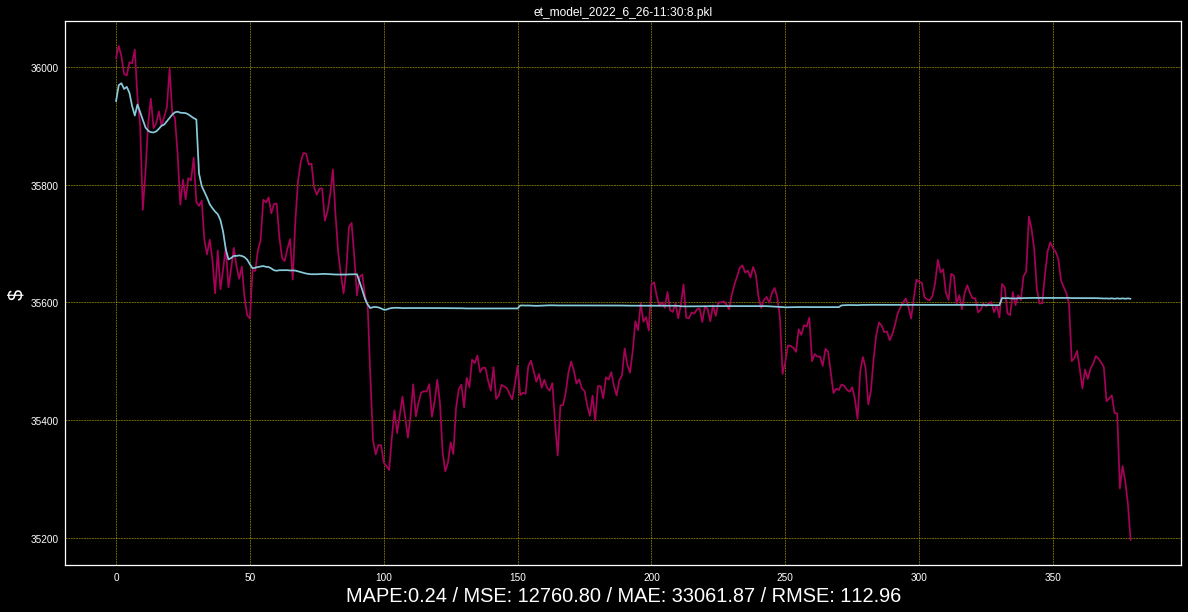

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ada_model_2022_6_26-11:30:46.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


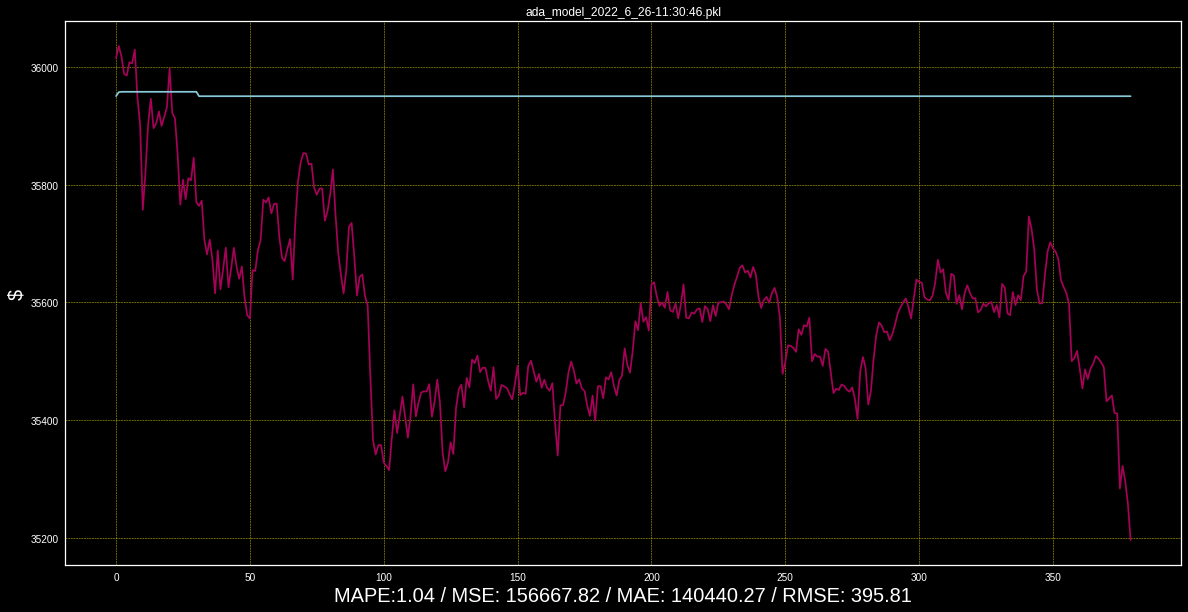

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/gbr_model_2022_6_26-11:31:4.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


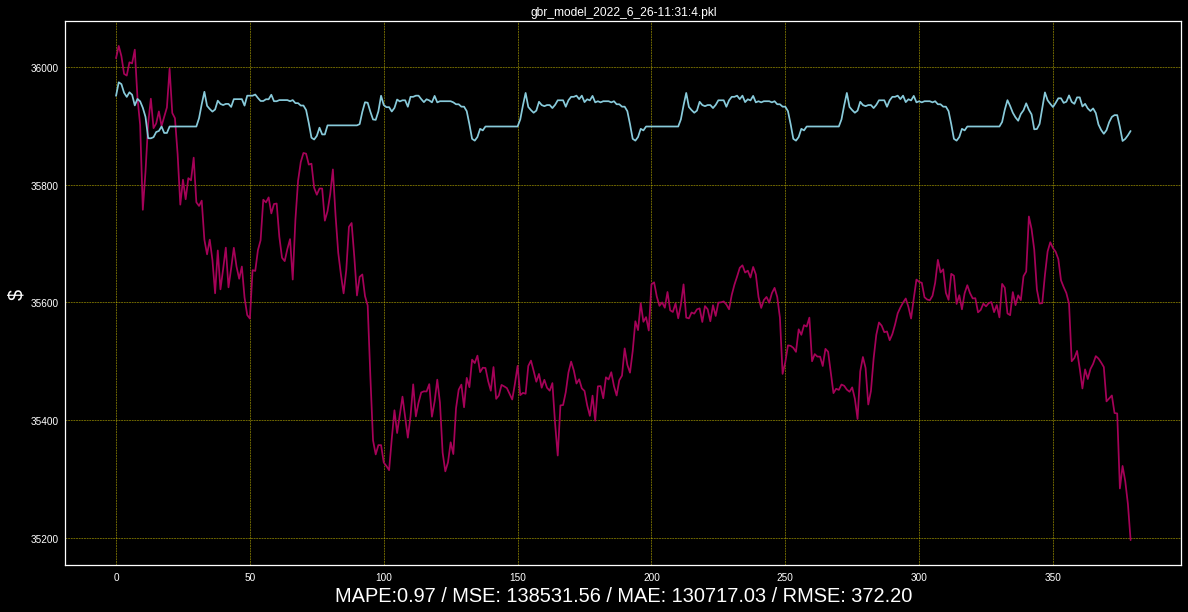

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/mlp_model_2022_6_26-11:32:49.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


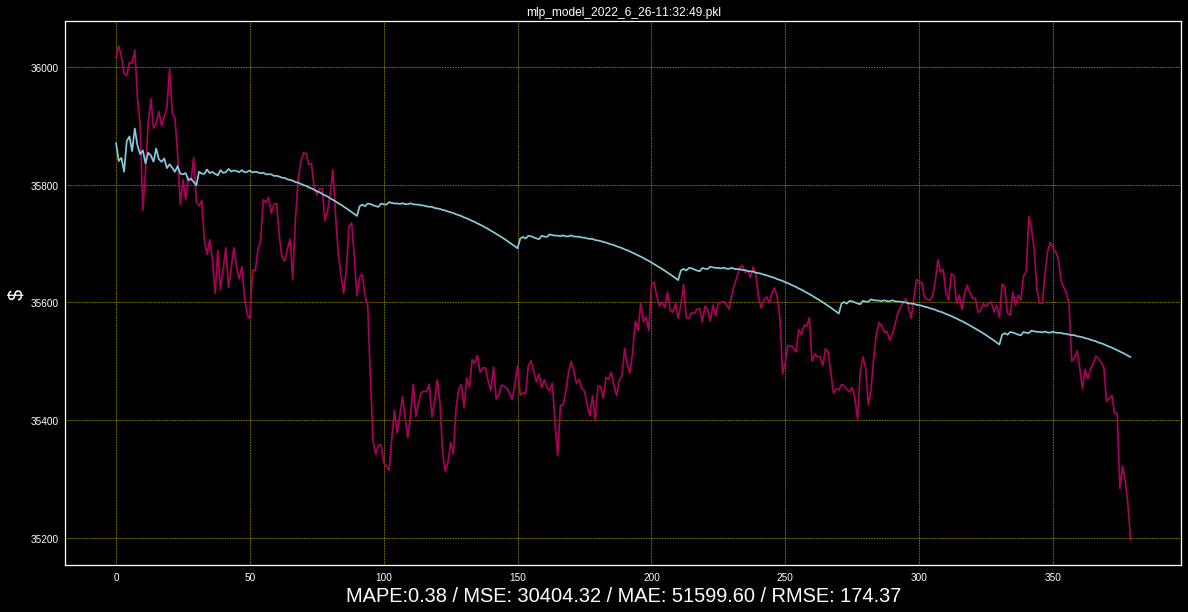

[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lightgbm_model_2022_6_26-11:32:58.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created


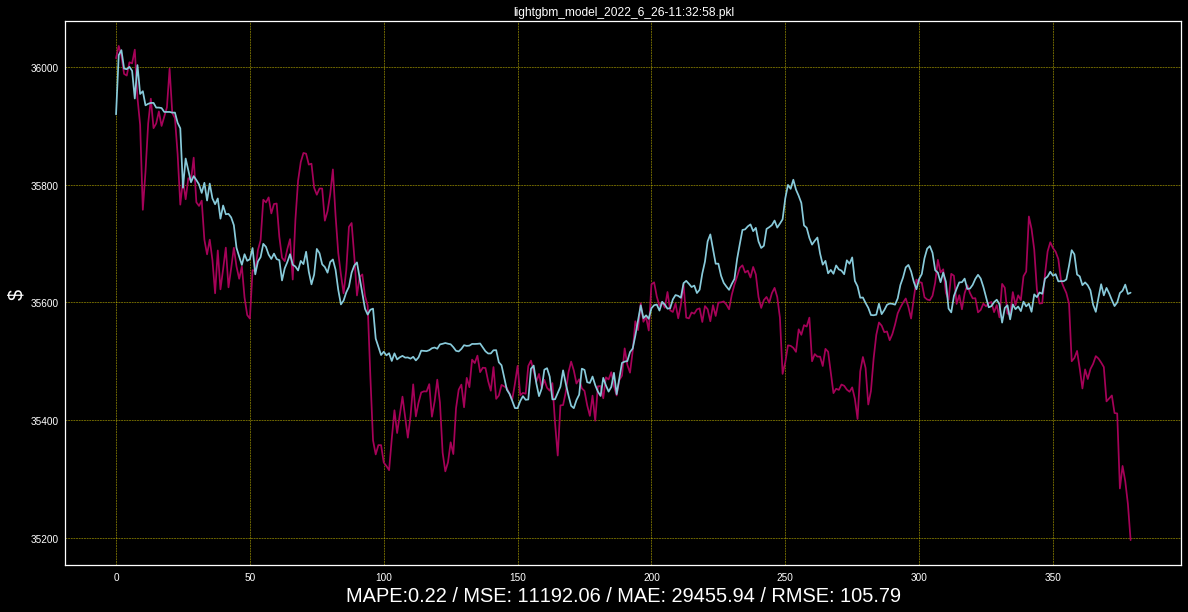

In [73]:
import matplotlib.pyplot as plt
import glob
import re

paths = glob.glob('/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/*.pkl',recursive = True)
files = os.listdir(r'/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/')

real = df[20:400].y.values

for i in range(len(paths)):
    forecasts = forecastor(df[:20],
                            model = paths[i],
                            forecast_range_min = 380,
                            num_of_lag = 10).Forecasts.values
    yhat = [float(i) for i in forecasts]

    plt.style.use(['dark_background'])
    plt.figure(figsize=(20,10))
    plt.plot(real, 'm')
    plt.plot(yhat , 'c')
    plt.title(files[i])
    plt.ylabel('$', fontsize=20)
    plt.xlabel('MAPE:%.2f / MSE: %.2f / MAE: %.2f / RMSE: %.2f' % (error_metrics.mape(real,yhat),
                                                                  error_metrics.mse(real,yhat),
                                                                  error_metrics.mae(real,yhat),
                                                                  error_metrics.rmse(real,yhat)),
              fontsize=20)
    plt.grid(color='y', linestyle='--', linewidth=0.5)
    plt.show()


# Better Models

In [76]:
better_models = {'lr':'Linear Regression',
                  'lasso': 'Lasso Regression',
                  'ridge': 'Ridge Regression',
                  'lar': 'Least Angle Regression',
                  'omp': 'Orthogonal Matching Pursuit',
                  'br': 'Bayesian Ridge',
                  'ransac': 'Random Sample Consensus',
                  'tr': 'TheilSen Regressor',
                  'lightgbm': 'Light Gradient Boosting Machine'
                  }

In [77]:
lr = forecastor(df[:20],
                model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lr_model_2022_6_26-11:24:45.pkl',
                forecast_range_min = 380,
                num_of_lag = 10).Forecasts.values

lasso = forecastor(df[:20],
                   model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lasso_model_2022_6_26-11:24:48.pkl',
                   forecast_range_min = 380,
                   num_of_lag = 10).Forecasts.values

ridge = forecastor(df[:20],
                   model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ridge_model_2022_6_26-11:24:51.pkl',
                   forecast_range_min = 380,
                   num_of_lag = 10).Forecasts.values

lar = lasso = forecastor(df[:20],
                         model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lar_model_2022_6_26-11:24:57.pkl',
                         forecast_range_min = 380,
                         num_of_lag = 10).Forecasts.values

omp = forecastor(df[:20],
                 model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl',
                 forecast_range_min = 380,
                 num_of_lag = 10).Forecasts.values

br = forecastor(df[:20],
                model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/br_model_2022_6_26-11:25:4.pkl',
                forecast_range_min = 380,
                num_of_lag = 10).Forecasts.values

ransac = forecastor(df[:20],
                    model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ransac_model_2022_6_26-11:25:21.pkl',
                    forecast_range_min = 380,
                    num_of_lag = 10).Forecasts.values

tr = forecastor(df[:20],
                model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/tr_model_2022_6_26-11:26:54.pkl',
                forecast_range_min = 380,
                num_of_lag = 10).Forecasts.values

lightgbm = forecastor(df[:20],
                      model = '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lightgbm_model_2022_6_26-11:32:58.pkl',
                      forecast_range_min = 380,
                      num_of_lag = 10).Forecasts.values


[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lr_model_2022_6_26-11:24:45.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created
[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lasso_model_2022_6_26-11:24:48.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created
[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ridge_model_2022_6_26-11:24:51.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obta

# Better Forecast Analyzing with Selected Models

In [78]:
better_forecasts = [lr,
                    lasso,
                    ridge,
                    lar,
                    omp,
                    br,
                    ransac,
                    tr,
                    lightgbm]

In [88]:
excellent_forecasts = []

for i in range(len(better_forecasts[0])):
    excellent_forecasts.append(np.mean([float(j[i]) for j in better_forecasts]))

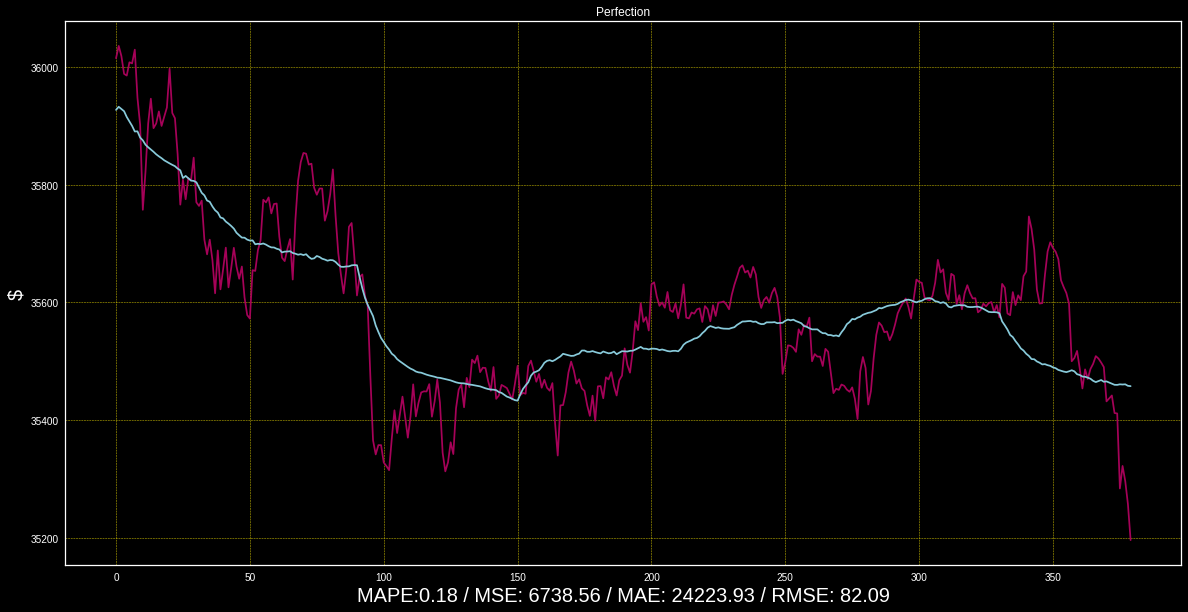

In [91]:
yhat = excellent_forecasts.copy()

plt.style.use(['dark_background'])
plt.figure(figsize=(20,10))
plt.plot(real, 'm')
plt.plot(yhat , 'c')
plt.title('Perfection')
plt.ylabel('$', fontsize=20)
plt.xlabel('MAPE:%.2f / MSE: %.2f / MAE: %.2f / RMSE: %.2f' % (error_metrics.mape(real,yhat),
                                                              error_metrics.mse(real,yhat),
                                                              error_metrics.mae(real,yhat),
                                                              error_metrics.rmse(real,yhat)),
          fontsize=20)
plt.grid(color='y', linestyle='--', linewidth=0.5)
plt.show()

In [92]:
better_forecasts_paths = ['/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lr_model_2022_6_26-11:24:45.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lasso_model_2022_6_26-11:24:48.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ridge_model_2022_6_26-11:24:51.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lar_model_2022_6_26-11:24:57.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/omp_model_2022_6_26-11:25:1.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/br_model_2022_6_26-11:25:4.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ransac_model_2022_6_26-11:25:21.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/tr_model_2022_6_26-11:26:54.pkl',
                          '/content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lightgbm_model_2022_6_26-11:32:58.pkl']

In [94]:
# Test Forecast
future = [
          forecastor(df[:400],
                      model = path,
                      forecast_range_min = 150,
                      num_of_lag = 10).Forecasts.values for path in better_forecasts_paths
         ]


[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lr_model_2022_6_26-11:24:45.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created
[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/lasso_model_2022_6_26-11:24:48.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obtaining Data
[SUCCESS]Data Successfully Obtained
[LOG]Forecasting Begining
[SUCCESS]Forecasting Successfully Done
[LOG]Creating Forecast Dataframe
[SUCCESS]Forecasting Dataframe Successfully Created
[LOG]Loading Model /content/drive/MyDrive/BIG_DATA_PROJECT/Model_Demo/ridge_model_2022_6_26-11:24:51.pkl
Transformation Pipeline and Model Successfully Loaded
[SUCCESS]Model Loaded Successfully
[LOG]Obta

# Forecasting Future of BTC - EUR Compharison

In [102]:
excellent_future = []
for i in range(150):
    excellent_future.append(np.mean([float(j[i]) for j in future]))

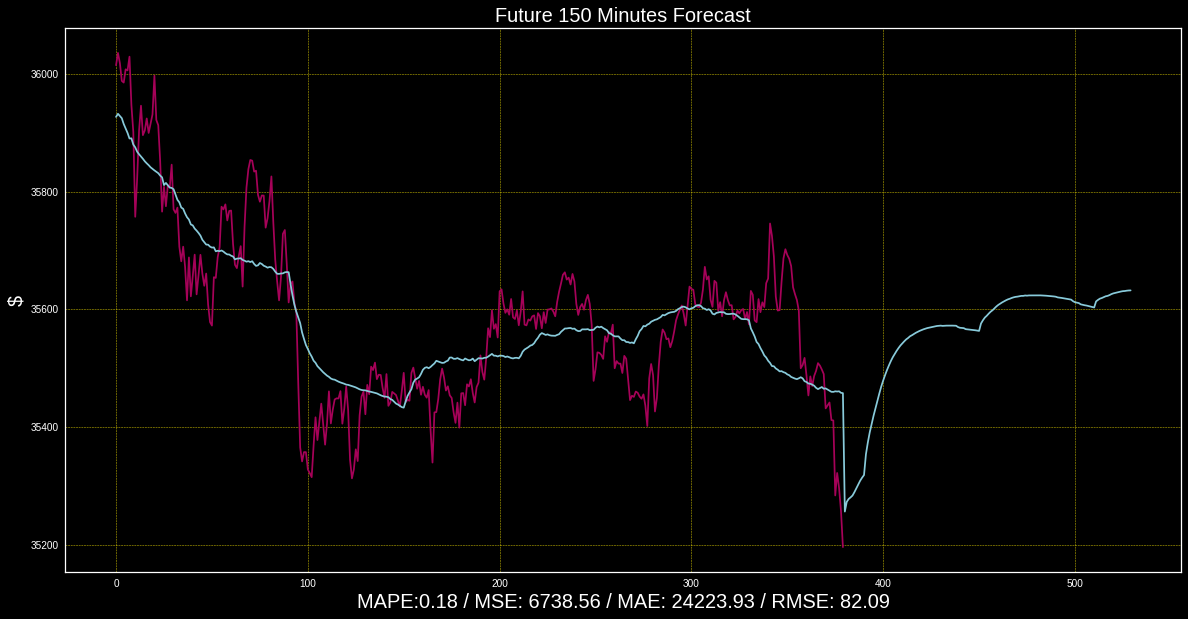

In [106]:
full_yhat = np.append(yhat, excellent_future)

plt.style.use(['dark_background'])
plt.figure(figsize=(20,10))
plt.plot(real, 'm')
plt.plot(full_yhat , 'c')
plt.title('Future 150 Minutes Forecast', fontsize=20)
plt.ylabel('$', fontsize=20)
plt.xlabel('MAPE:%.2f / MSE: %.2f / MAE: %.2f / RMSE: %.2f' % (error_metrics.mape(real,yhat),
                                                              error_metrics.mse(real,yhat),
                                                              error_metrics.mae(real,yhat),
                                                              error_metrics.rmse(real,yhat)),
          fontsize=20)
plt.grid(color='y', linestyle='--', linewidth=0.5)
plt.show()